<a href="https://colab.research.google.com/github/mdr356/tensorflow-dog-cat-cnn/blob/master/tensorflow_dog_cat_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import cv2

**Downloading Dog and Cat images**
The dataset we have downloaded has the following directory structure.
cats_and_dogs_filtered
```
|__ train
    |______ cats: [cat.0.jpg, cat.1.jpg, cat.2.jpg ...]
    |______ dogs: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ validation
    |______ cats: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ...]
    |______ dogs: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
```

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**file path for the training and validation sets.**

In [4]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

# print number of data
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000



Images must be formatted into appropriately pre-processed floating point tensors before being fed into the network. The steps involved in preparing these images are:

* Read images from the disk
* Decode contents of these images and convert it into proper grid format as per their RGB content
* Convert them into floating point tensors
* Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done using the class **tf.keras.preprocessing.image.ImageDataGenerator**.

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


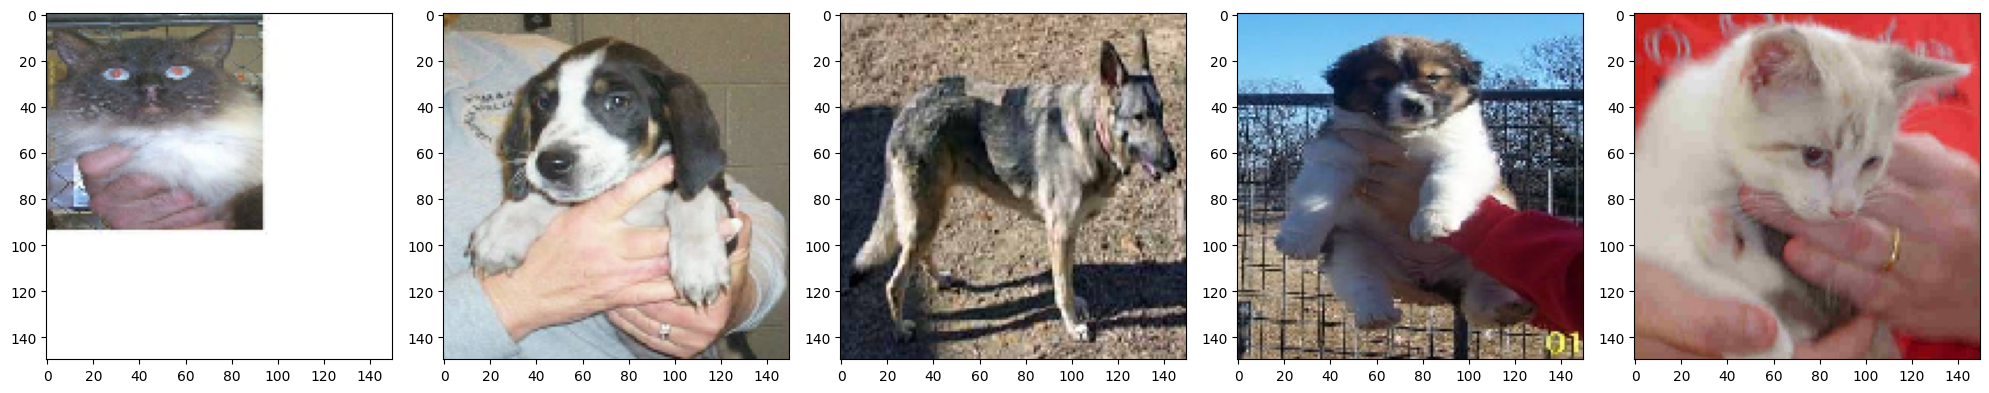

In [5]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

# After defining our generators for training and validation images,
## flow_from_directory method will load images from the disk,
### apply rescaling, and resize them using single line of code.

train_data_gen = train_image_generator.flow_from_directory(batch_size=100,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(150, 150),
                                                           class_mode='binary')
validation_data_gen = validation_image_generator.flow_from_directory(batch_size=100,
                                                                     directory=validation_dir,
                                                                     shuffle=False,
                                                                     target_size=(150, 150),
                                                                     class_mode='binary')

#plotting the image
sample_training_images, _ = next(train_data_gen)
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

plotImages(sample_training_images[:5])  # Plot images 0-4

**Model**
Create a sequensial model with Con2D of 32 followed by MaxPooling 2x2 with a stride of 2. which will be followed by another set of Conv2D with output of 64 and maxpooling then go up to 128 units of Con2D and Maxpooling. We will then flatten the data from 2D to 1D array, follow by a fully connected layer and a dense layer output of 2 wiht softmax activiation.

In [19]:
# create the layers ImageDataGenerator rescaled the image, shuffle it, resize it to 150x150.
## passing it throught the conv layers.

# a 3x3 scanner with activation relu and shape is 150x150 depth is 3 for RGB (color image)
# output of 32 layers.
l0 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3))
l1 = tf.keras.layers.MaxPooling2D(2, 2)

l2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')
l3 = tf.keras.layers.MaxPooling2D(2, 2)

l4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')
l5 = tf.keras.layers.MaxPooling2D(2, 2)

l6 = tf.keras.layers.Flatten() # flatten from 2D to 1D
l7 = tf.keras.layers.Dense(512, activation='relu')

# output are two options
l8 = tf.keras.layers.Dense(2, activation='softmax')

model = tf.keras.models.Sequential([
    l0,
    l1,
    l2,
    l3,
    l4,
    l5,
    l6,
    l7,
    l8
])

#compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
model.summary()
# train the data
# Since our batches are coming from a generator (ImageDataGenerator), we'll use fit_generator instead of fit.
EPOCHS = 20
# fit the model
history = model.fit(train_data_gen, epochs=20, validation_data=validation_data_gen)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,034,690 (72.61 MB)

 Trainable params: 19,034,690 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 200ms/step - accuracy: 0.4982 - loss: 1.6442 - val_accuracy: 0.5180 - val_loss: 0.6878
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step - accuracy: 0.5700 - loss: 0.6807 - val_accuracy: 0.5740 - val_loss: 0.6690
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.6317 - loss: 0.6388 - val_accuracy: 0.6290 - val_loss: 0.6585
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.6727 - loss: 0.5903 - val_accuracy: 0.6670 - val_loss: 0.6332
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.7646 - loss: 0.4931 - val_accuracy: 0.6630 - val_loss: 0.6523
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.7949 - loss: 0.4369 - val_accuracy: 0.6690 - val_loss: 0.6480
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.8316 - loss: 0.4079 - val_accuracy: 0.6450 - val_loss: 0.7069
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 0.8424 - loss: 0.3676 - val_accuracy: 0.

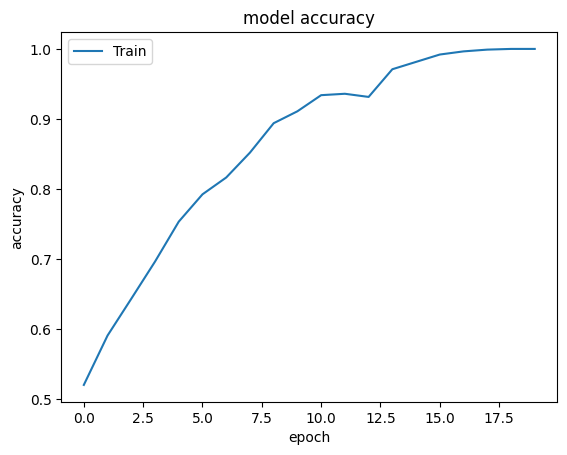

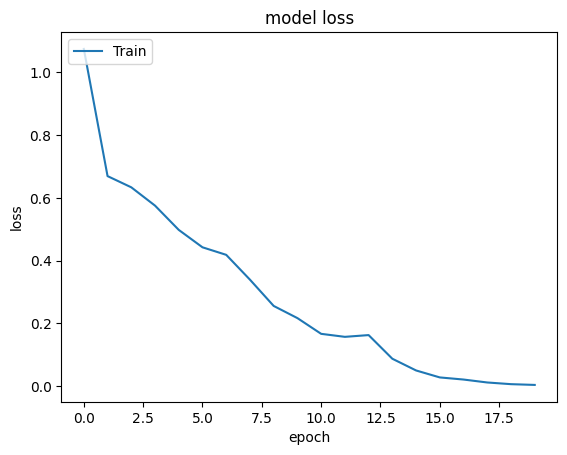

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(100)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
